In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install efficientnet_pytorch

In [3]:
import torchvision, time, os, copy
import torch.nn as nn
import torch.optim as optim
import torch, json
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2 as cv
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from albumentations import ShiftScaleRotate
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook as tqdm
from efficientnet_pytorch import EfficientNet

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        #transforms.ColorJitter(brightness = 0.5),
        transforms.Resize((256,256)),
        #transforms.CenterCrop(150),
        transforms.ToTensor(), 
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
}


TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [4]:
train_image_datasets = datasets.ImageFolder(TRAINING_DATA_FOLDER, data_transforms['train'])
test_image_datasets = datasets.ImageFolder(TESTING_DATA_FOLDER, data_transforms['test'])

In [5]:
# Creating data indices for training and validation splits:
dataset_size = len(train_image_datasets)

indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(322)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
print(dataset_size)

2183


In [6]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True)
dataloaders = {'train': train_loader,'val':validation_loader}
dataset_sizes = {'train':len(train_loader.sampler),'val':len(validation_loader.sampler)}
class_names = train_image_datasets.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
# Helper function for displaying images
def imshow(images, title=None):
    # Clip just in case
    images = np.clip(images.permute(1, 2, 0), 0, 1)
    plt.imshow(images)
    plt.pause(0.001)  # pause a bit so that plots are updated

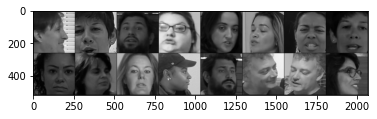

In [9]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
grid = torchvision.utils.make_grid(inputs)

imshow(grid)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1).type(torch.cuda.FloatTensor))
                    preds = torch.round(torch.sigmoid(outputs))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.unsqueeze(1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            scheduler.step()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time

In [11]:
# Download a pre-trained ResNet18 model and freeze its weights
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
# Set the loss function
criterion = nn.BCEWithLogitsLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Loaded pretrained weights for efficientnet-b0
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.5960 Acc: 0.6777



val Loss: 0.6882 Acc: 0.5000

Epoch 2/10
----------



train Loss: 0.4273 Acc: 0.8197



val Loss: 0.6755 Acc: 0.5367

Epoch 3/10
----------



train Loss: 0.3077 Acc: 0.8815



val Loss: 0.5961 Acc: 0.6904

Epoch 4/10
----------



train Loss: 0.2363 Acc: 0.9090



val Loss: 0.4710 Acc: 0.7775

Epoch 5/10
----------



train Loss: 0.1741 Acc: 0.9319



val Loss: 0.4286 Acc: 0.8119

Epoch 6/10
----------



train Loss: 0.1561 Acc: 0.9410



val Loss: 0.4550 Acc: 0.8005

Epoch 7/10
----------



train Loss: 0.1388 Acc: 0.9485



val Loss: 0.3838 Acc: 0.8394

Epoch 8/10
----------



train Loss: 0.1355 Acc: 0.9508



val Loss: 0.3121 Acc: 0.8761

Epoch 9/10
----------



train Loss: 0.1562 Acc: 0.9502



val Loss: 0.2963 Acc: 0.8739

Epoch 10/10
----------



train Loss: 0.1378 Acc: 0.9554



val Loss: 0.2663 Acc: 0.8830

Training complete in 2m 54s
Best val Acc: 0.883028


In [12]:
predictions = []
testlabels = []
for idx, (inputs, labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  preds = torch.round(torch.sigmoid(outputs))
  testlabels.extend(labels.cpu().detach().numpy())
  predictions.extend(preds.cpu().detach().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
f1_score(predictions, testlabels, average="macro")

0.8409090909090909